# 本章内容总结

本节将在 iris 数据库上执行二进制分类。我们将推断一种花是 I.setosa 或者不是。

我们将创建一个简单的二进制分类器，通过创建一条线并通过 sigmoid 函数运行本章前面几节的内容来创建推断器。我们将用到两个特征：花足长和花足宽。之所以用这两个特征是因为 iris setosa 可以通过这两个特征分离。我们的目标是找到能将其分开的这条线。

我们将采用批量训练（batch training），但这很容易的换成随机训练（stochastic training）（比如：设置 batch size 为 1）。

好了，先加载必要的库并重置计算图

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

### 加载 Iris 数据

我们加载 iris 数据并标记目标是否为 I.setosa。输入数据将会是数据库中的第三个和第四个特征数据。（Petal Length 和 Petal width）

In [2]:
# 加载 iris 数据
# iris.target = {0, 1, 2}, 0：是 setosa
# iris.data ~ [sepal.width, sepal.length, pedal.width, pedal.length]
iris = datasets.load_iris()
binary_target = np.array([1. if x == 0 else 0. for x in iris.target])
iris_2d = np.array([[x[2], x[3]] for x in iris.data])

我们设置 batch size 为 20

In [3]:
batch_size = 20

然后我们启动计算图会话

In [4]:
sess = tf.Session()

### 占位符（Placeholders）

我们声明占位符，只为说明我们可分别喂养多个 x-特征，我们为两个 iris  特性创建了两个独立的占位符

In [5]:
# 声明占位符
x1_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x2_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

### 模型变量

我们要做一个线性模型，所以我们需要创建两个变量 A（slope）和 b（intercept）。

In [6]:
# 创建变量 A 和 b
A = tf.Variable(tf.random_normal(shape=[1, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

### 模型操作

线可被定义为：$x_1 = A \cdot x_2 + b$。要创建一个线性分隔符，我们希望看到数据点落在线的哪一边，有三种情况：

- 点在线中，将满足：$0 = x_1 - (A \cdot x_2 + b)$
- 点在线上，将满足：$0 > x_1 - (A \cdot x_2 + b)$
- 点在线下，将满足：$0 < x_1 - (A \cdot x_2 + b)$

我们将制作模型的输出数据：

$$x_1 - (A \cdot x_2 + b)$$

然后预测值将是上述模型输出的标识：

$$Prediction(x_1, x_2) = sign(x_1 - (A \cdot x_2 + b))$$

因此我们把相应的操作添加到计算图。

In [7]:
# 添加模型到图
# x1 - A*x2 + b
my_mult = tf.matmul(x2_data, A)
my_add = tf.add(my_mult, b)
my_output = tf.subtract(x1_data, my_add)

### 损失函数

由于我们正在做一个分类预测（是 setosa 或不是），我们将使用 sigmoid 交叉熵损失函数。

In [8]:
# 添加分类损失函数
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output, labels=y_target)

### 优化函数和变量初始化

我们使用标准梯度递减优化函数，学习率为 0.05。然后添加并运行变量初始化操作。

In [9]:
# 创建优化器
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

### 运行分类

迭代 1000 次并每 200 次输出 A, b 和 损失值。

In [10]:
# Run loop
for i in range(1000):
    rand_index = np.random.choice(len(iris_2d), size=batch_size)
    rand_x = iris_2d[rand_index]
    rand_x1 = np.array([[x[0]] for x in rand_x])
    rand_x2 = np.array([[x[1]] for x in rand_x])
    # rand_y = np.transpose([binary_target[rand_index]])
    rand_y = np.array([[y] for y in binary_target[rand_index]])
    sess.run(train_step, feed_dict={x1_data: rand_x1, x2_data: rand_x2, y_target: rand_y})
    if (i+1) % 200 == 0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ', b = ' + str(sess.run(b)))

Step #200 A = [[ 8.60584927]], b = [[-3.49741817]]
Step #400 A = [[ 10.09685612]], b = [[-4.662817]]
Step #600 A = [[ 11.11085701]], b = [[-5.32012033]]
Step #800 A = [[ 11.79205132]], b = [[-5.92699575]]
Step #1000 A = [[ 12.36329174]], b = [[-6.37421751]]


### 可视化结果

我们根据 A 和 b 绘制直线，并给出预测结果。

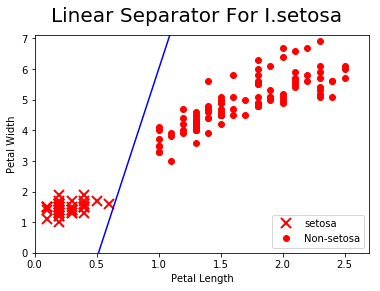

In [11]:
# Pull out slope/intercept
[[slope]] = sess.run(A)
[[intercept]] = sess.run(b)

# 创建拟合直线
x = np.linspace(0, 3, num=50)
ablineValues = []
for i in x:
    ablineValues.append(slope*i + intercept)

# 在数据上绘制拟合线
setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==1]
setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==1]
non_setosa_x = [a[1] for i,a in enumerate(iris_2d) if binary_target[i]==0]
non_setosa_y = [a[0] for i,a in enumerate(iris_2d) if binary_target[i]==0]
plt.plot(setosa_x, setosa_y, 'rx', ms=10, mew=2, label='setosa')
plt.plot(non_setosa_x, non_setosa_y, 'ro', label='Non-setosa')
plt.plot(x, ablineValues, 'b-')
plt.xlim([0.0, 2.7])
plt.ylim([0.0, 7.1])
plt.suptitle('Linear Separator For I.setosa', fontsize=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(loc='lower right')
plt.show()